In [239]:
from solver import classic_solver
from aspen import aspen_solver
import partion
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

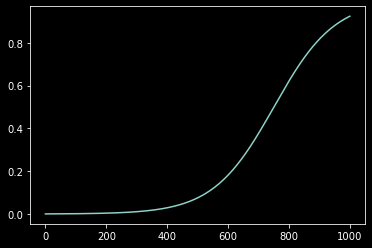

In [324]:
# inital condition

x0 = 1/ (1+ np.exp(-0.01*(np.arange(1000)-750)) )
x0 = np.reshape(x0, (-1, 1))
plt.plot(x0)

In [325]:
Nx = 1000
Nt = 20
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
solver_cl = classic_solver(param, D)
solver_cl.setBoundary(0, 1)
solver_cl.x0 = np.copy(x0)
#solver_cl.setInitial(0.5, 2, 1)
solver_cl.setSources([0.6], [0])

X_cl, code, message = solver_cl.solve()
print(X_cl, message)

[[5.52778637e-04 9.29910972e-05 4.21872340e-05 ... 2.46600233e-04
  2.54302460e-04 0.00000000e+00]
 [5.58331053e-04 1.20955838e-04 8.08315262e-05 ... 4.92356176e-04
  5.07685795e-04 0.00000000e+00]
 [5.63939209e-04 1.48593218e-04 1.19245391e-04 ... 7.36753434e-04
  7.59667690e-04 0.00000000e+00]
 ...
 [9.22011765e-01 9.88010889e-01 9.96334657e-01 ... 9.98814324e-01
  9.98834088e-01 0.00000000e+00]
 [9.22727798e-01 9.89504192e-01 9.97403651e-01 ... 9.99211790e-01
  9.99224942e-01 0.00000000e+00]
 [9.23437803e-01 9.91000363e-01 9.98467034e-01 ... 9.99606845e-01
  9.99613426e-01 0.00000000e+00]] OK


In [326]:
Nx = 1000
Nt = 20
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)

part = partion.partion_equally
solver_as = aspen_solver(param, D, part)
solver_as.setBoundary(0, 1)
solver_as.x0 = np.copy(x0)
#solver_as.setInitial(0.5, 2, 1)
solver_as.setSources([0.6], [0])
X, code, message = solver_as.solve()
print(X, message)

[[5.52778637e-04 5.98057287e-05 4.01719703e-05 ... 2.46142727e-04
  2.53867435e-04 0.00000000e+00]
 [5.58331053e-04 8.84663786e-05 7.85326869e-05 ... 4.91886499e-04
  5.07238850e-04 0.00000000e+00]
 [5.63939209e-04 1.16783022e-04 1.16676426e-04 ... 7.36271665e-04
  7.59208901e-04 0.00000000e+00]
 ...
 [9.22011765e-01 9.95183692e-01 9.96921454e-01 ... 9.98815427e-01
  9.98835044e-01 0.00000000e+00]
 [9.22727798e-01 9.96807197e-01 9.97954000e-01 ... 9.99212686e-01
  9.99225722e-01 0.00000000e+00]
 [9.23437803e-01 9.98435874e-01 9.98980201e-01 ... 9.99607534e-01
  9.99614031e-01 0.00000000e+00]] OK


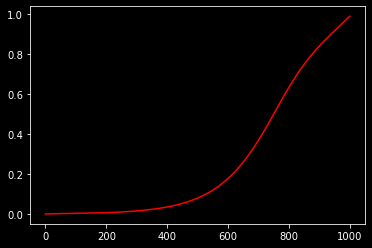

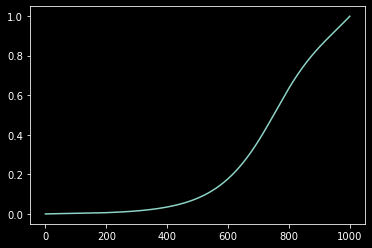

OK


In [339]:
step = 1
plt.style.use('dark_background')
plt.plot(X_cl[:, step], color = 'r')
plt.show()
plt.plot(X[:, step])
plt.show()
print(message)

In [328]:
print('aspen/newton comparsion')
print('---global versus newton---')
print('gb_resbld = {}, resbld ={}'.format(solver_as.timelog.gb_resbld, solver_cl.timelog.resbld))
print('gb_jacbld = {}, jacbld = {}'.format(solver_as.timelog.gb_jacbld, solver_cl.timelog.jacbld))
print('gb_linsol = {}, linsol = {}'.format(solver_as.timelog.gb_linsol, solver_cl.timelog.linsol))
print('---local+global time vs newton time---')
t1 = solver_as.timelog.gb_resbld+solver_as.timelog.gb_jacbld \
      +solver_as.timelog.gb_linsol+np.sum(solver_as.timelog.lc_resbld) \
      +np.sum(solver_as.timelog.lc_jacbld)+np.sum(solver_as.timelog.lc_linsol)
t2 = solver_cl.timelog.resbld+solver_cl.timelog.jacbld \
      +solver_cl.timelog.linsol
print('aspen = {}, newton = {}'.format(t1, t2))

aspen/newton comparsion
---global versus newton---
gb_resbld = 0.6590538024902344, resbld =1.5942656993865967
gb_jacbld = 0.5883529186248779, jacbld = 2.3946192264556885
gb_linsol = 0.2980000972747803, linsol = 0.9638073444366455
---local+global time vs newton time---
aspen = 3.5130021572113037, newton = 4.952692270278931


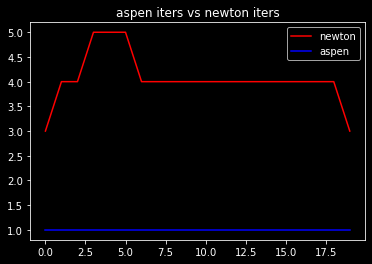

In [331]:
plt.title('aspen iters vs newton iters')
plt.plot(solver_cl.timelog.kn[:-1], color = 'r', label='newton')
plt.plot(solver_as.timelog.aspen_iters[:-1], color = 'b', label='aspen')
plt.legend()
plt.show()

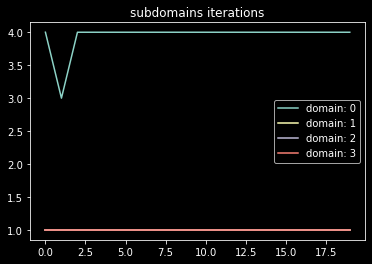

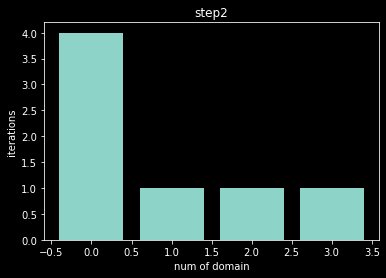

In [332]:
plt.title('subdomains iterations')

for i in range(Nd):
    plt.plot(solver_as.timelog.domain_iters[:-1, i], label='domain: {}'.format(i))
    
plt.legend()
plt.show()

plt.title('step2')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_as.timelog.domain_iters[2, :])
plt.show()

In [330]:
print('subdomain time')
print('---resbld---')
print(solver_as.timelog.lc_resbld)
print('---jacbld---')
print(solver_as.timelog.lc_jacbld)
print('---linsol---')
print(solver_as.timelog.lc_linsol)

subdomain time
---resbld---
[0.3903079  0.15055561 0.14685488 0.15324712]
---jacbld---
[0.6137836  0.14675426 0.14948153 0.14130211]
---linsol---
[0.04556036 0.01023889 0.00986648 0.0096426 ]
